In [79]:
# General imports
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt  # add this import

In [80]:
# Specific imports
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [81]:
# Training and testing folders
train_path = "augmented_images/train/"
valid_path = "augmented_images/val/"

In [82]:
# Get train and test files
image_files = glob(train_path + "/*/*.jp*g")
valid_image_files = glob(valid_path + "/*/*.jp*g")

In [83]:
# Get number of classes
folders = glob(train_path + "/*")

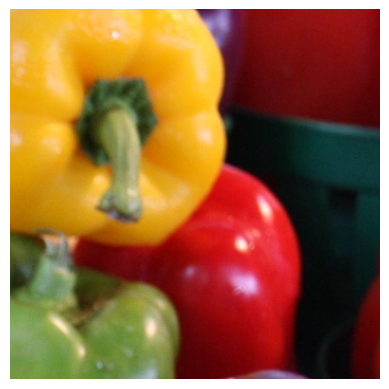

In [84]:
# Display any random image
plt.imshow(plt.imread(np.random.choice(image_files)))
plt.axis("off")
plt.show()

In [85]:
# Resize all the images to this
IMAGE_SIZE = [100, 100]

In [86]:
# Training config
epochs = 12
batch_size = 32

In [87]:
# Load pre-trained VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

In [88]:
# Freeze existing weights
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation="softmax")(x)

In [89]:
# Create Model
model = Model(inputs=vgg.input, outputs=prediction)

In [90]:
# View structure of the model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [91]:
# Configure model
model.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
)

In [92]:
# Create an instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255,
    preprocessing_function=preprocess_input,
)

In [93]:
# Get label mapping of class and label number
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 280 images belonging to 8 classes.
{'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7}


In [94]:
# Create generators for training and validation
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size,
)

Found 560 images belonging to 8 classes.
Found 280 images belonging to 8 classes.


In [95]:
# Fit the model
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/12


C:\Users\agift\AppData\Local\Temp\ipykernel_10092\3220640474.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


17/17 [==============================] - 3s 123ms/step - loss: 1.6730 - accuracy: 0.4091 - val_loss: 1.4229 - val_accuracy: 0.5039
Epoch 2/12
17/17 [==============================] - 2s 105ms/step - loss: 1.1125 - accuracy: 0.6439 - val_loss: 1.0799 - val_accuracy: 0.6055
Epoch 3/12
17/17 [==============================] - 2s 104ms/step - loss: 0.9437 - accuracy: 0.6856 - val_loss: 1.1998 - val_accuracy: 0.5781
Epoch 4/12
17/17 [==============================] - 2s 108ms/step - loss: 0.7888 - accuracy: 0.7519 - val_loss: 1.0797 - val_accuracy: 0.6367
Epoch 5/12
17/17 [==============================] - 2s 105ms/step - loss: 0.7194 - accuracy: 0.7822 - val_loss: 0.9999 - val_accuracy: 0.6406
Epoch 6/12
17/17 [==============================] - 2s 104ms/step - loss: 0.6468 - accuracy: 0.8087 - val_loss: 0.9446 - val_accuracy: 0.6367
Epoch 7/12
17/17 [==============================] - 2s 108ms/step - loss: 0.6106 - accuracy: 0.7898 - val_loss: 1.0666 - val_accuracy: 0.6094
Epoch 8/12
17/17 

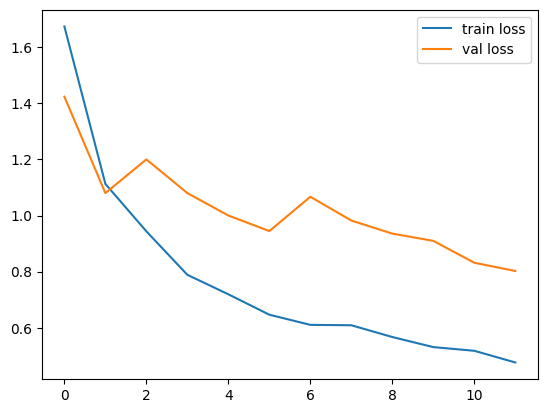

In [96]:
# Plot the train and validation loss
plt.plot(r.history["loss"], label="train loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend()
plt.show()

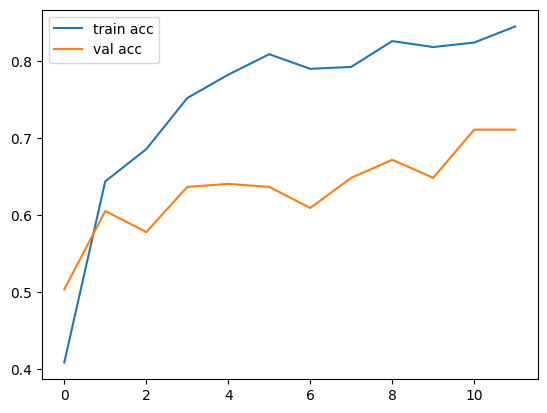

Final training accuracy = 0.8446969985961914
Final validation accuracy = 0.7109375


In [97]:
# Plot the train and validation accuracies
plt.plot(r.history['accuracy'], label='train acc')  # 'acc' is changed to 'accuracy'
plt.plot(r.history['val_accuracy'], label='val acc')  # 'val_acc' is changed to 'val_accuracy'
plt.legend()
plt.show()

print("Final training accuracy = {}".format(r.history["accuracy"][-1]))
print("Final validation accuracy = {}".format(r.history["val_accuracy"][-1]))

In [98]:
# Simpan model setelah pelatihan selesai
model.save("model/disaster.h5")

In [99]:
# Visualizing predictions
result = np.round(model.predict_generator(valid_generator))

C:\Users\agift\AppData\Local\Temp\ipykernel_10092\1810151809.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  result = np.round(model.predict_generator(valid_generator))


In [100]:
import random

In [101]:
test_files = []
actual_res = []
test_res = []

In [102]:
for i in range(0, 3):
    rng = random.randint(0, len(valid_generator.filenames))
    test_files.append(valid_path + valid_generator.filenames[rng])
    actual_res.append(valid_generator.filenames[rng].split("/")[0])
    test_res.append(labels[np.argmax(result[rng])])

In [103]:
from IPython.display import Image, display

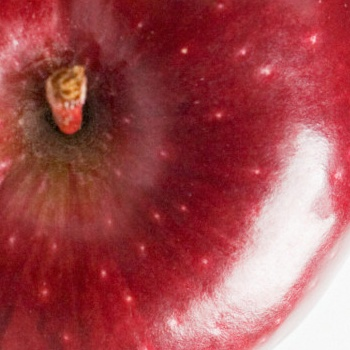

Actual class: apple\Image_3_8.jpg
Predicted class: apple


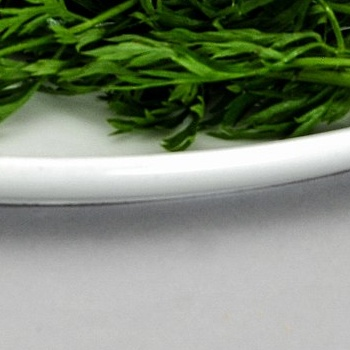

Actual class: carrot\Image_3_5.jpg
Predicted class: carrot


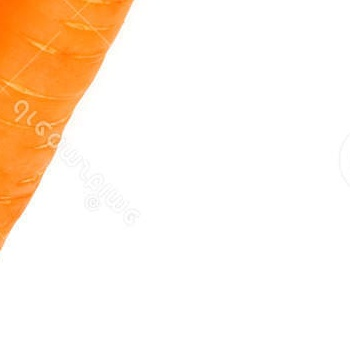

Actual class: carrot\Image_6_8.jpg
Predicted class: carrot


In [104]:
for i in range(0, 3):
    display(Image(test_files[i]))
    print("Actual class: " + str(actual_res[i]))
    print("Predicted class: " + str(test_res[i]))